Выполнил: Тихонов Сергей, БЭК181

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm, chi2 
from statsmodels.tsa.seasonal import STL
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.ets import AutoETS

from sklearn.ensemble import GradientBoostingRegressor
from sktime.forecasting.compose import make_reduction
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.naive import NaiveForecaster

import warnings
warnings.simplefilter(action="ignore")
plt.rcParams["figure.figsize"] = (23,9)

##### 1) Загрузка данных и визуальный анализ (1 балл)

Загрузите данные из файла atm.csv. Рекомендуется для нормальной работы некоторых фукнций перевести индекс в тип PeriodIndex. Например, можно создать date_range с нужной частотой. Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

In [54]:
# Загрузка данных

data = pd.read_csv('atm.csv')

data.drop('Unnamed: 0', axis=1, inplace=True)
data.index = pd.date_range(start="2015-01-01", periods=len(data), freq="D")

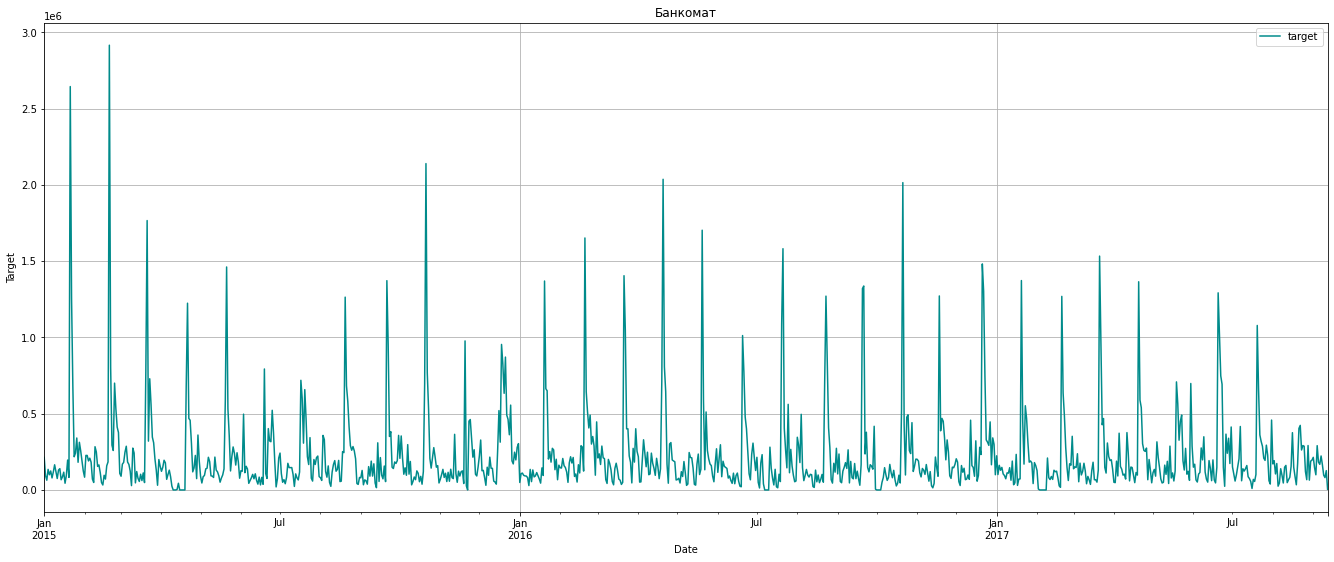

In [55]:
# График ряда

data.plot(color='darkcyan')
plt.title('Банкомат')
plt.xlabel('Date')
plt.ylabel('Target')
plt.grid(visible=1);

**Наблюдения по графику ряда** (без коррелограмм):

Структура ряда: 

* Структурных изменений замечено не было.

Наличие тренда: 

* Явного тренда на графике не наблюдается - объем наличности в банкомате не должен расти в нормальных условиях функционирования экономики,  поэтому тренда не ожидается.

Сезонность:

* В рамках года каждый месяц видны скачки, что говорит о месячной сезонности. Этот факт будет подтвержден ниже.

Цикличность:

* На приведеном интервали какие либо циклы, кроме сезонных, **отсутствуют**.

Стационарность:

* Более правильно будет проверить стационарность с помощью коррелограмм (выполнено ниже), однако подозревается нарушение предпосылки о постоянной дисперсии. По тренду ряд стационарен.


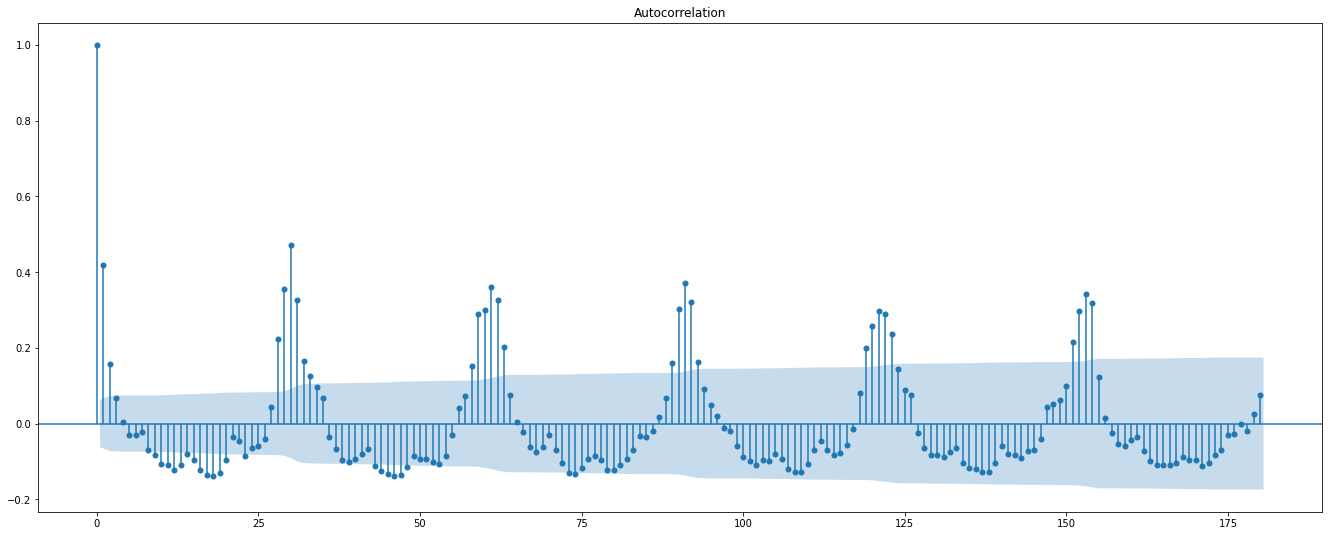

In [56]:
# ACF в уровнях

plot_acf(data, lags=180);

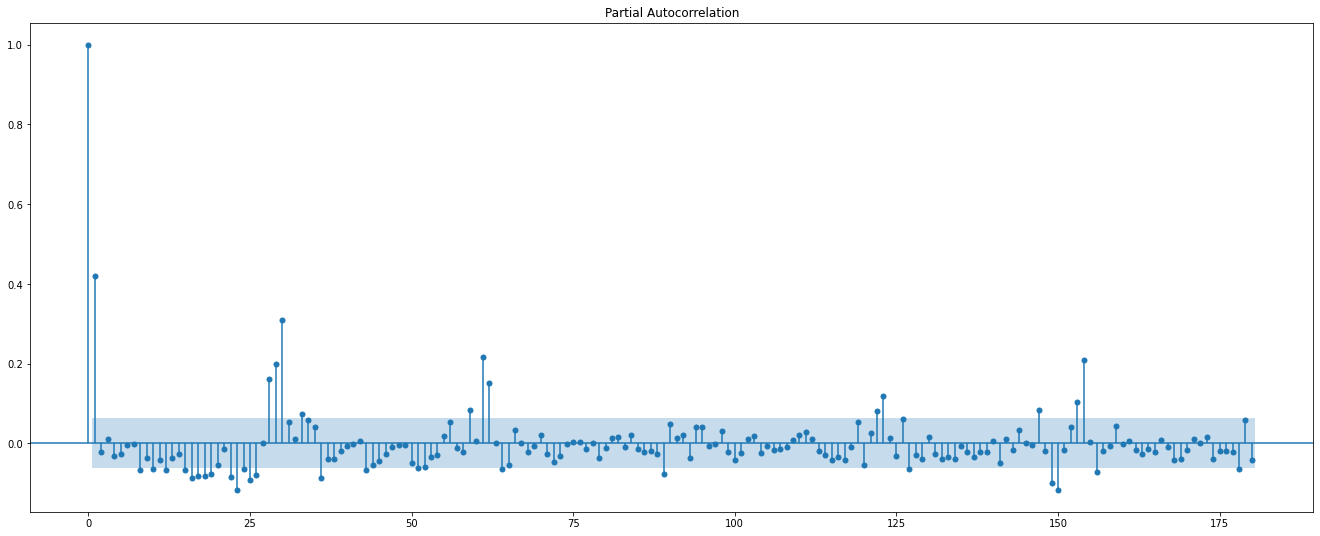

In [57]:
# PACF в уровнях

plot_pacf(data, lags=180);

**Выводы по ACF/PACF**:

Сезонность

* Для определения сезонности посмотрим на значимость отдельных лагов. По графику ACF легко заметить, что значим каждый 31 лаг (и его окрестность), а значит имеет место месячная сезонность. Аналогичные паттерны можно заметить на графике PACF.

Стационарность

* Автокорреляционная функция **не** убывает очень медленно, причём лаги быстро перестают быть значимыми;

* Частная автокорреляционная функция имеет несколько сильных значимых лагов, а многие следующие незначимы;

=> Это признаки стационарного ряда. 

##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 30 дней.

Как легко заметить, данные неотрицательны. Но давайте на случай использования мультипликативных ETS-моделей их децентрируем. К тренировочной части прибавьте произвольную небольшую константу (например 100 рублей). Обратите внимание, что константу придётся вычесть из прогнозов итоговой модели при подсчёте метрик относительно теста.

Дополнительно можете произвести обратимые преобразования, которые сочтёте необходимыми.

In [58]:
# Разбиение на трейн и тест

y_train, y_test = temporal_train_test_split(data, test_size=30)
y_train = y_train + 100

## Покомпонентное прогнозирование

В данном разделе мы попробуем пофильтровать ряд с помощью двух моделей: STL-разложения и ETS-модели.

### Блок 1. STL

##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL-разложение. В качестве параметра period возьмите самый сильный лаг автокорреляций. Визуализируйте отдельные компоненты.

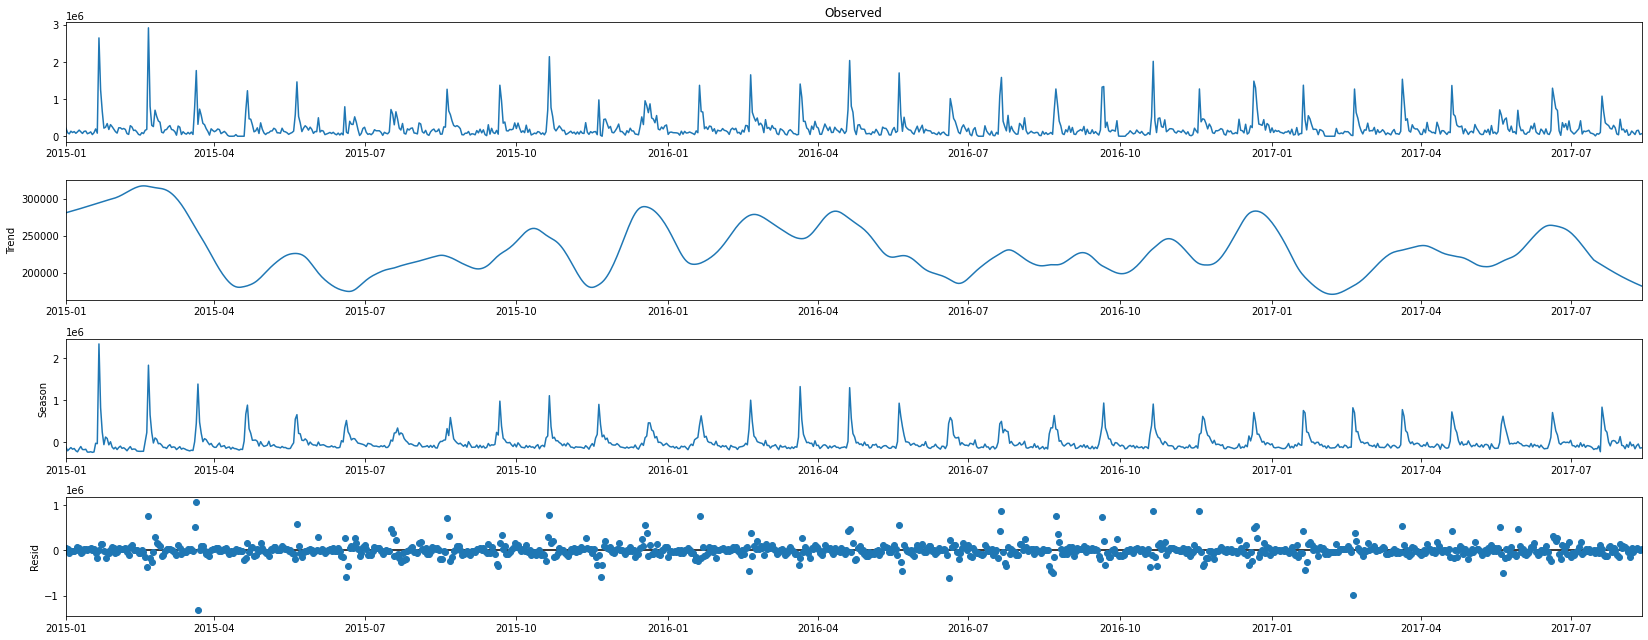

In [59]:
# STL декомпозиция

stl = STL(y_train, period=30)
res = stl.fit()

res.plot();

##### Прогнозирование отдельных компонент (0.6 балла)

Возьмём выделенные из STL компоненты. Постройте какие-нибудь простые модели (без фичей) для тренда и сезонности.

Например, для тренда можно взять модель полиномального тренда из sktime. Для сезонности можно использовать NaiveForecaster с указанием периодичности. Спрогнозируйте каждую компоненту 30 шагов (по 0.3 за каждую компоненту).

In [60]:
# Тренд

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster_trend = PolynomialTrendForecaster(RandomForestRegressor(), 2)
forecaster_trend.fit(res.trend)
y_pred_trend = forecaster_trend.predict(fh)

In [61]:
# Сезонность

forecaster_season = NaiveForecaster(sp=30)
forecaster_season.fit(res.seasonal)
y_pred_season = forecaster_season.predict(fh)

#### Прогнозирование остатков. 

##### Подготовка данных (0.9 балла)

Достанем временной ряд остатков из STL-разложения. Построим отдельную модель с остатками STL в качестве таргета и потом сложим с прогнозами отдельных компонент из предыдущего шага. Получим этакий бутерброд. Прогнозируем отдельно на 30 шагов каждую компоненту: тренд, сезонность и ошибку, а потом суммируем прогнозы.

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение.

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

Я создал 3 вида *моих* фичей, т.к. это поможет с прогнозированием:

1. День завоза денег. По графику ряда можно легко определить потенциальные дни завоза денег в банкомат - 19, 20, 21 числа каждого месяца. В данном контексте будем считать, что на праздниках деньги в банкомат завозить не будут, тк работники отдыхают. При этом переменная вперёд смотрящая, что хорошо! 

2. Курс доллара. Экзогенная фича. Предполагаем, что чем выше курс, тем меньше денег в банкомате. Люди активно снимают средства и тратят их (на покупку товаров или валюты).

3. Синус/косинус по дням. Поможет выделить сезонные паттерны. Здесь утечки отсутствуют, поскольку таргет не участвует в формировании фичи.

In [165]:
# Предобработка

X_train = pd.read_csv('events.csv')
X_train['Date'] = X_train['Unnamed: 0']
X_train.drop('Unnamed: 0', axis=1, inplace=True)
X_train.Date = pd.to_datetime(X_train.Date)

y_train['Date'] = y_train.index
X_train = pd.merge(X_train, y_train, how='left', on='Date').dropna()
y_train.drop('Date', axis=1, inplace=True)

y_res1 = y_train.squeeze() - res.trend - res.seasonal

X_train = X_train.loc['2015-01-01':]

In [166]:
# Дата завоза денег в банкомат И не праздник

X_train['day_of_month'] = X_train.Date.dt.day

X_train['19_day'] = ((X_train['day_of_month'] == 19) & (X_train['праздник'] != 1)).astype('int')
X_train['20_day'] = ((X_train['day_of_month'] == 20) & (X_train['праздник'] != 1)).astype('int')
X_train['21_day'] = ((X_train['day_of_month'] == 21) & (X_train['праздник'] != 1)).astype('int')

X_train.drop('day_of_month', axis=1, inplace=True)

In [167]:
# Курс доллара

exchange = pd.read_csv("currency.csv", decimal=',', delimiter=',')
exchange.Date = pd.to_datetime(exchange.Date, dayfirst=True)

X_train = pd.merge(X_train, exchange, how='left', on='Date').fillna(method='ffill')
X_train.Exchange = X_train.Exchange.shift(1).fillna(method='bfill')

In [168]:
# Синус и косинус

timestamp_s = X_train.Date.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

X_train['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
X_train['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [169]:
# Постобработка

X_train.index = X_train.Date
X_train.dropna(inplace=True)
y_res1 = X_train.target
y_res1 = y_res1.asfreq('D')
X_train.drop(['Date', 'target'], axis=1, inplace=True)

#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков STL на трейне. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Так как нас интересуют именно многошаговые прогнозы, стандартная кросс-валидация нам не подойдёт. Выберите любой из двух методов кросс-валидации временных рядов (скользящее или расширяющееся окно) на ваше усмотрение.

 Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Ширина окна 35 при горизонте 30 -- сомнительная практика.


**Комментарий студента**: так как мы считаем, что ряд стационарный, то его ранние наблюдения не будут мешать в предсказании, поэтому логично реализовать CV с расширяющимся окном. 

In [202]:
class CustomCrossVal(object):
    def __init__(self, window_size = 300, step=50):

       
        self.window_size = window_size
        self.step = step

    def split(self, X):

        window = self.window_size
        
        for _ in range((len(X) - self.window_size) // self.step + 1):

            train_indexes = [i for i in range(0, window - self.step)]
            test_indexes = [i for i in range(window - self.step, window)]
            
            window += self.step
            
            yield train_indexes, test_indexes

##### Отбор моделей (0.5 балла)

Выберите 3-4 модели-кандидата и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

In [200]:
def candidate_test(model_name, CustomCrossVal, y_res):
    
    mae = []

    for train_indexes, test_indexes in CustomCrossVal.split(X_train):
        
        X_train_val, y_train_val = X_train.iloc[train_indexes], y_res.iloc[train_indexes]
        X_test_val, y_test_val = X_train.iloc[test_indexes], y_res.iloc[test_indexes]
        
        model = model_name
        
        forecaster = make_reduction(model, window_length=15, strategy="direct")
        fh = ForecastingHorizon(y_test_val.index, is_relative=False)
        forecaster.fit(y_train_val, X=X_train_val, fh=fh)
        y_pred = forecaster.predict(fh, X=X_test_val)


        mae.append(mean_absolute_error(y_test_val, y_pred))
    
    return np.mean(mae)  

In [190]:
# Случайный лес

candidate_test(RandomForestRegressor(n_estimators=15), CustomCrossVal(window_size = 300, step=30), y_res1)

141170.7676767677

In [76]:
# Бустинг

candidate_test(GradientBoostingRegressor(n_estimators=15), CustomCrossVal(window_size = 300, step=30), y_res1)

135177.31557785845

In [203]:
# Линейная регрессия

candidate_test(LinearRegression(), CustomCrossVal(window_size = 300, step=30), y_res1)

209578.27152912953

**Промежуточный вывод**: лучшее качество по метрике MAE показал случайный лес.

##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель на всём трейне и постройте прогноз на тестовый период. Используйте любую из многошаговых стратегий, но прямая будет самым простым решением. 

In [86]:
# Прогноз на 30 шагов вперед с помощью градиентного бустинга

regressor = GradientBoostingRegressor(n_estimators=15)
forecaster = make_reduction(regressor, window_length=10, strategy="direct")

forecaster.fit(y_res1, X=X_train, fh=fh) 
y_pred = forecaster.predict(fh=fh)

##### Бэктестинг (1 балл)

Обучив наилучшую модель на трейне, вычтите из y_train тренд и сезонность (полученные из STL), а также прогноз вашей модели отатков на трейн. Таким образом вы получите остатки вашей совокупной модели на трейне. Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Реализуйте тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. $\alpha = 0.05$. (0.5 балла)

Если гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

In [220]:
# Для получения остатков:

gb = GradientBoostingRegressor(n_estimators=15)
gb.fit(X_train, y_res1)
y_pred_error = gb.predict(X_train)

residual = y_train.squeeze() - res.trend - res.seasonal - y_pred_error.squeeze()

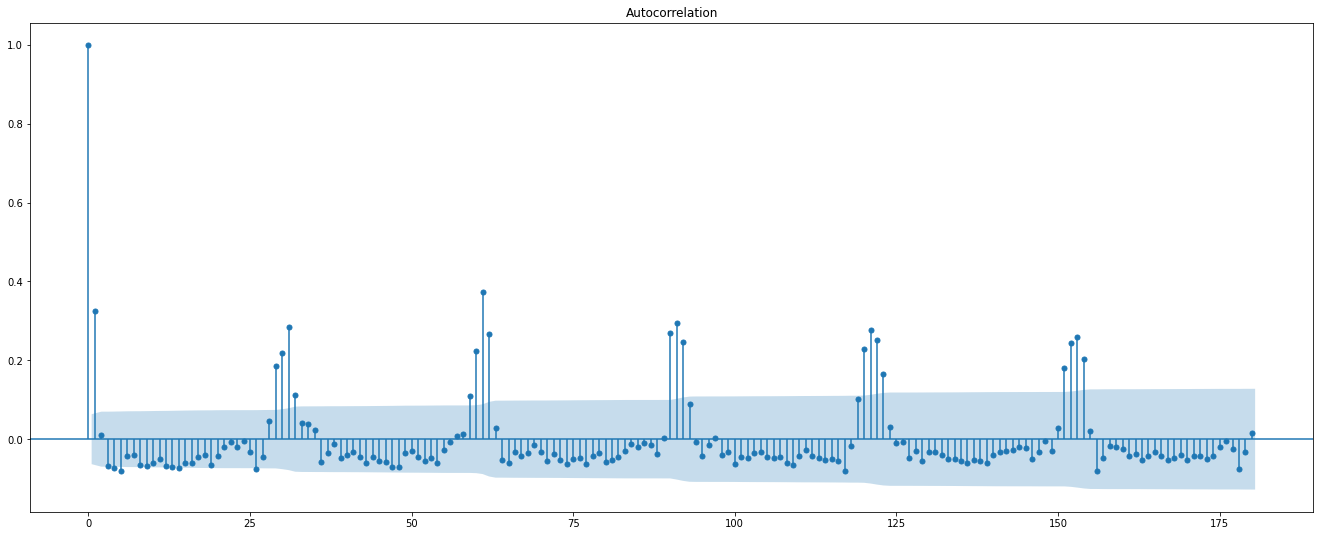

In [221]:
# ACF остатков

plot_acf(residual, lags=180);

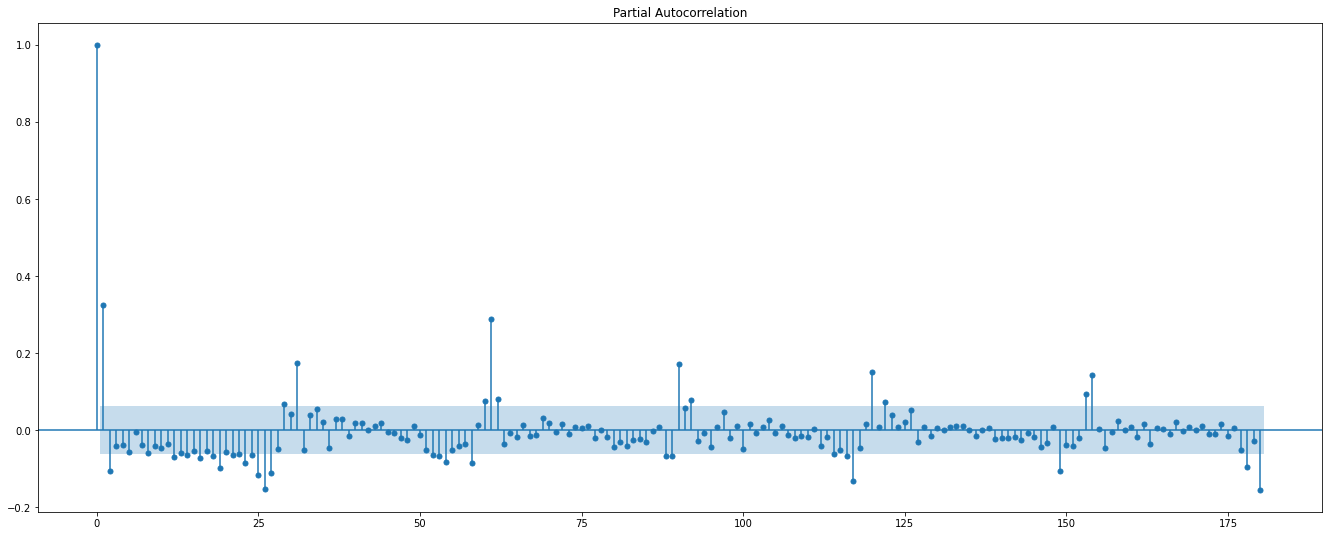

In [222]:
# PACF остатков

plot_pacf(residual, lags=180);

**Вывод по ACF/PACF**: Видно, что в целом получен график, характерный для белого шума (абсолютное большинство автокорреляционный и частных автокорреляций). Однако, есть много значимых сезонных паттернов, которые значимы. Таким образом, чтобы убедиться в отсутствии автокорреляции остатков, проведём соответствующий тест Ljung-Box'a. 

In [223]:
def LjungBox(residual, m):

    n_obs = len(residual)
    corrs_corrected = [np.corrcoef(residual[k:], residual.shift(k)[k:])[0][1]/(n_obs-k) for k in range(1, m+1)]

    test_stat = np.sum(np.square(corrs_corrected)) * n_obs * (n_obs + 2)
    
    print(1-chi2.cdf(test_stat, m))

In [224]:
LjungBox(residual, 8)

0.999999283260988


In [225]:
LjungBox(residual, 10)

0.9999999872560962


In [226]:
LjungBox(residual, 15)

0.9999999999995918


**Вывод по Ljung-Box**:

p-value = 1 > 0.05 = $\alpha$ , значит нулевая гипотеза об отсуствии автокорреляции остатков не отвергается. В результате, делаем вывод об отсутствии автокорреляции остатков.

Бонус! (0.5 балла)

Реализуйте тест Бройша-Годфри. Описание можно почерпнуть из [Википедии](https://en.wikipedia.org/wiki/Breusch–Godfrey_test). Протестируйте остатки на наличие автокорелляций. Изменился ли результат?

Основная модель:

$$y_t = X_t \beta + \varepsilon_t$$

Вспомогательная модель:

$$e_t = X_t \beta + \sum_{i=1}^{m}a_i e_{t-i} + u_t$$

$H_0: a_1 = ... = a_m = 0$

$H_1: \text{Хотя бы одно равенство нарушено}$

In [227]:
import statsmodels.api as sm

X = X_train.copy()
m = 8

# Основная регрессия

X = sm.add_constant(X)
model = sm.OLS(y_train, X)
results = model.fit()
residuals = results.resid

# Вспомогательная регрессия
for i in range(1, m+1):
    
    X = pd.concat([X, residuals.shift(i)], axis=1)

X.dropna(inplace=True)
model = sm.OLS(residuals[m:], X)
results = model.fit() 

chi_obs = len(X) * results.rsquared
print(1-chi2.cdf(chi_obs, m))

2.3052406042833873e-05


**Вывод**: p-value = 0, нулевая гипотеза отвергается, а значит имеет место автокорреляция остатков. Результаты тестов не совпадают. Сверим с версией со statsmodels:

In [216]:
# Сверим со statsmodels версией

import statsmodels.stats.diagnostic as dg

X = X_train.copy()
m = 8

model = sm.OLS(y_train, X).fit()

print(dg.acorr_breusch_godfrey(model, nlags=m)[3])

2.8815455935680674e-05


**Вывод**: имплементация получилась правильной, но результаты теста Box-Ljung и Breusch-Godfrey не совпадают. Первый показал отсуствтие автокорреляции остатков, тогда как второй показал наличие автокорреляции остатков. 

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза. Подсчитайте MAE сезонного наивного прогноза (на каждой точке теста -- последнее наблюдение за аналогичный день в предыдущем месяце, 30 дней назад). Справилась ли ваша модель лучше?

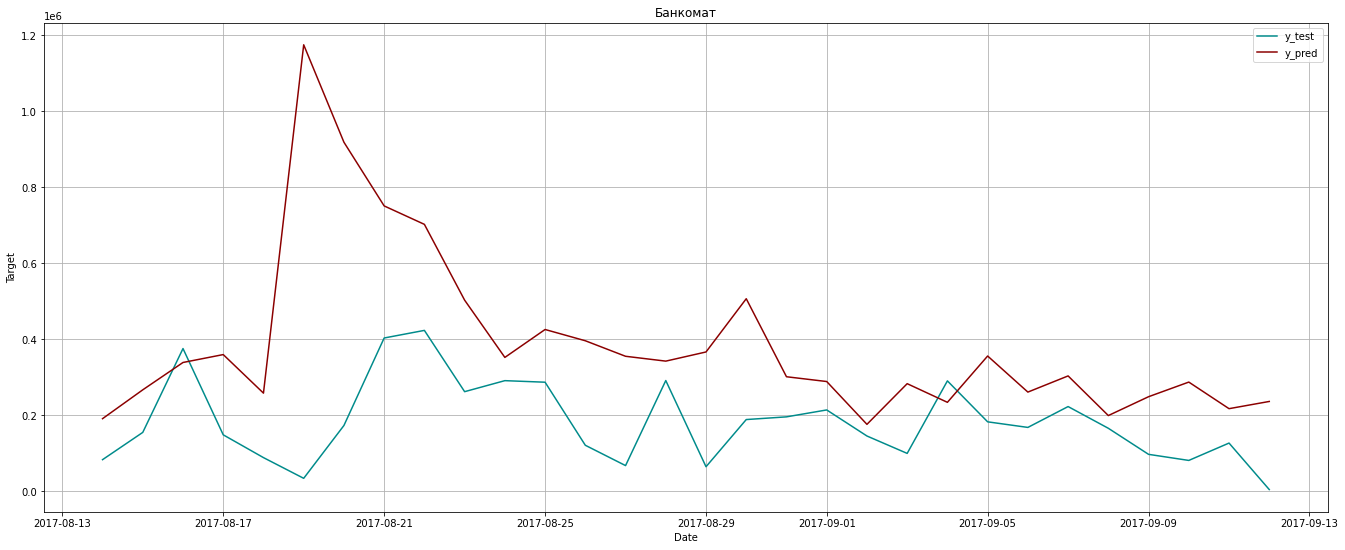

In [218]:
y_pred_stl = y_pred_trend + y_pred_season + y_pred.squeeze() - 100

plt.plot(y_test.index, y_test, label='y_test', color='darkcyan')
plt.plot(y_test.index, y_pred_stl, label='y_pred', color='darkred')
plt.title('Банкомат')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(visible=1);

In [96]:
mean_absolute_error(y_test, y_pred_stl)

211282.04309771556

In [97]:
# Сезонная наивная модель

forecaster_season = NaiveForecaster(sp=30)
forecaster_season.fit(y_train)
y_naive = forecaster_season.predict(fh)

mean_absolute_error(y_test, y_naive)

147860.0

**Вывод**: нет, модель не справилась лучше сезонного наивного прогноза.

### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем одновременно одной ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

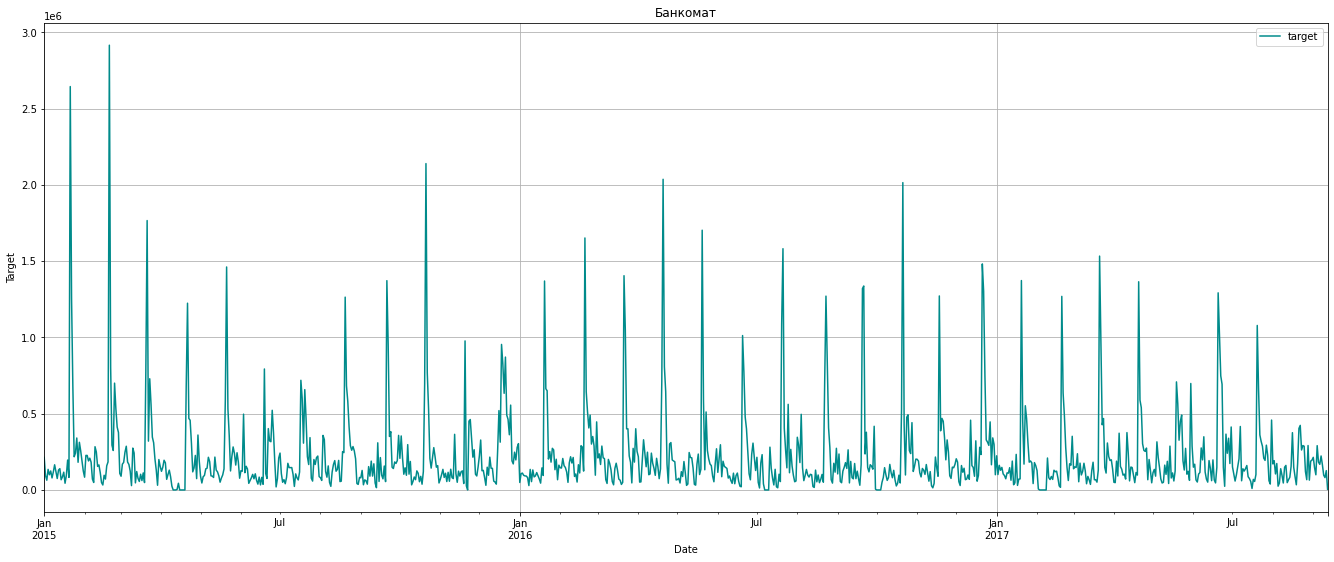

In [98]:
# График исходного ряда ещё раз

data.plot(color='darkcyan')
plt.title('Банкомат')
plt.xlabel('Date')
plt.ylabel('Target')
plt.grid(visible=1);

**Ошибка**

Аддитивность ошибки подтверждается природой данных, поскольку мы знаем, что речь идёт об объеме наличности в банкомате. С другой стороны, стоит рассмотреть мультипликативную, так как в некоторых местах есть расширяющиеся паттерны.

**Сезонность**

Сезонность точно имеется (обозначили этот факт в первой половине ДЗ). Сезонные компоненты могут быть как аддитивными (не меняется амплитуда), так и мультипликативными (меняется амплитуда).

**Тренд**

На графике ряда ни аддитивного, ни мультипликативного тренда нет. Более того, в первой части домашнего задания мы решили, что ряд стационарный (по крайней мере по тренду). Таким образом, рассмотрим модели точно без тренда.

In [99]:
# Сетка параметров

param_grid = {
    'error': ['add', 'mul'],
    'trend': ['add', None],
    'seasonal': ['add', 'mul']
}

##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [100]:
# Кросс валидация

forecaster = AutoETS(sp=30)
fh = ForecastingHorizon(list(range(1, len(y_test)+1)))

cv = ExpandingWindowSplitter(
    initial_window=700,
    step_length=len(y_test),
    fh=fh)

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    scoring=MeanAbsoluteError(),
    cv=cv,
    n_jobs=-1
    )

gscv.fit(y_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64', is_relative=True),
            initial_window=None, step_length=30),
                        forecaster=AutoETS(sp=30), n_jobs=-1,
                        param_grid={'error': ['add', 'mul'],
                                    'seasonal': ['add', 'mul'],
                                    'trend': ['add', None]},
                        scoring=MeanAbsoluteError())

In [101]:
# Оптимальные параметры

gscv.best_params_

{'error': 'add', 'seasonal': 'add', 'trend': None}

**Промежуточный вывод**: Получили то, что предполагали в предыдущем пункте!

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне. Они будут использованы в качестве таргета для второй модели. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

In [102]:
# Предобработка

y_res2 = gscv.best_forecaster_.predict_residuals()
y_res2 = pd.DataFrame(y_res2, index=y_res2.index, columns=['target'])

X_train = pd.read_csv('events.csv')
X_train['Date'] = X_train['Unnamed: 0']
X_train.drop('Unnamed: 0', axis=1, inplace=True)
X_train.Date = pd.to_datetime(X_train.Date)

y_res2['Date'] = y_res2.index
X_train = pd.merge(X_train, y_res2, how='left', on='Date').dropna()
y_res2.drop('Date', axis=1, inplace=True)

X_train = X_train.loc['2015-01-01':]

# y_train для остатков = y_res

In [103]:
X_train['day_of_month'] = X_train.Date.dt.day

X_train['19_day'] = ((X_train['day_of_month'] == 19) & (X_train['праздник'] != 1)).astype('int')
X_train['20_day'] = ((X_train['day_of_month'] == 20) & (X_train['праздник'] != 1)).astype('int')
X_train['21_day'] = ((X_train['day_of_month'] == 21) & (X_train['праздник'] != 1)).astype('int')

X_train.drop('day_of_month', axis=1, inplace=True)

In [104]:
timestamp_s = X_train.Date.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

X_train['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
X_train['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [105]:
# Постобработка

X_train.index = X_train.Date
X_train.dropna(inplace=True)
y_res2 = X_train.target
y_res2 = y_res2.asfreq('D')
X_train.drop(['Date', 'target'], axis=1, inplace=True)

##### Отбор моделей остатков и кросс-валидация (0.5 баллов)

Отберите 3-4 модели-кандидата для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен 30, как длина теста. Используйте реализованный ранее класс для кросс-валидации. 

In [108]:
candidate_test(RandomForestRegressor(n_estimators=15), CustomCrossVal(window_size = 300, step=30), y_res2)

146850.79894152356

In [109]:
candidate_test(GradientBoostingRegressor(n_estimators=15), CustomCrossVal(window_size = 300, step=30), y_res2)

139806.6776145679

In [110]:
candidate_test(LinearRegression(), CustomCrossVal(window_size = 300, step=30), y_res2)

210490.57237815688

##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём трейне. Постройте прогноз на тест с помощью любой многошаговой стратегии. Как и ранее, проще всего использовать прямую.

In [111]:
# Прогноз на 30 шагов вперед с помощью случайного леса

regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, window_length=10, strategy="direct")

forecaster.fit(y_res2, X=X_train, fh=fh) 
y_pred_ets = forecaster.predict(fh=fh)

##### Бэктестинг (0.5 балла)

Класс ETS-модели не позволяет напрямую получить прогноз на трейне. Но позволяет сразу получить остатки на трейне. Возьмите эти остатки и вычтите из них прогноз второй модели. Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков. Протестируйте их на наличие серийных автокорреляций любым из тестов, реализованных ранее.

In [112]:
# Для получения остатков:

rf = RandomForestRegressor()
rf.fit(X_train, y_res2)
y_pred_error = rf.predict(X_train)

residual = y_res2 - y_pred_error

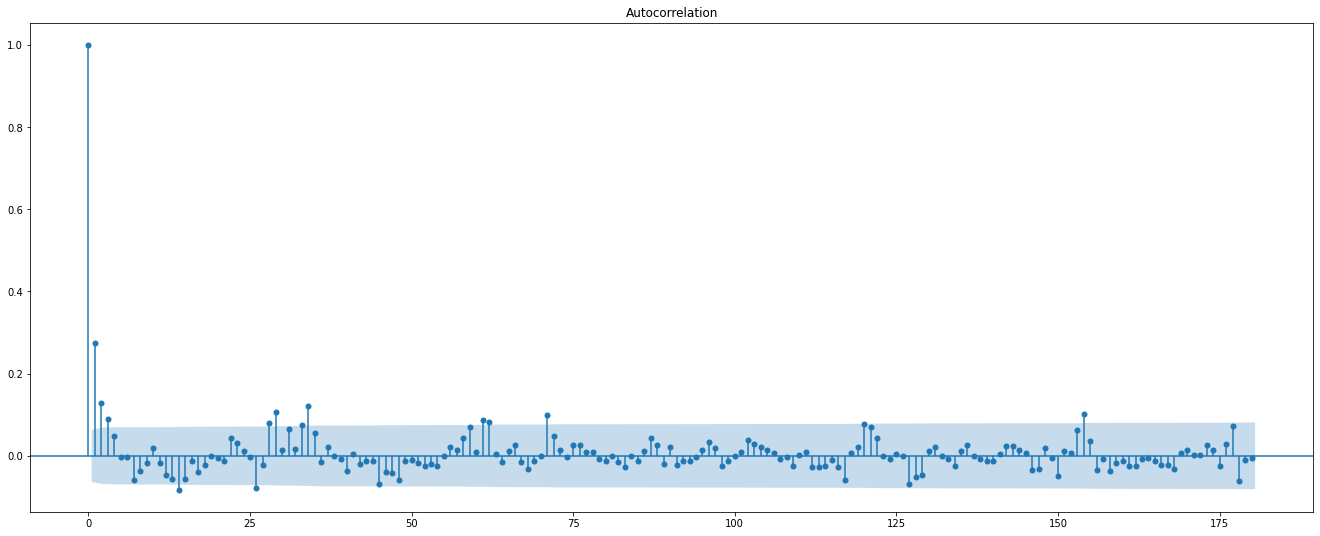

In [113]:
# ACF остатков

plot_acf(residual, lags=180);

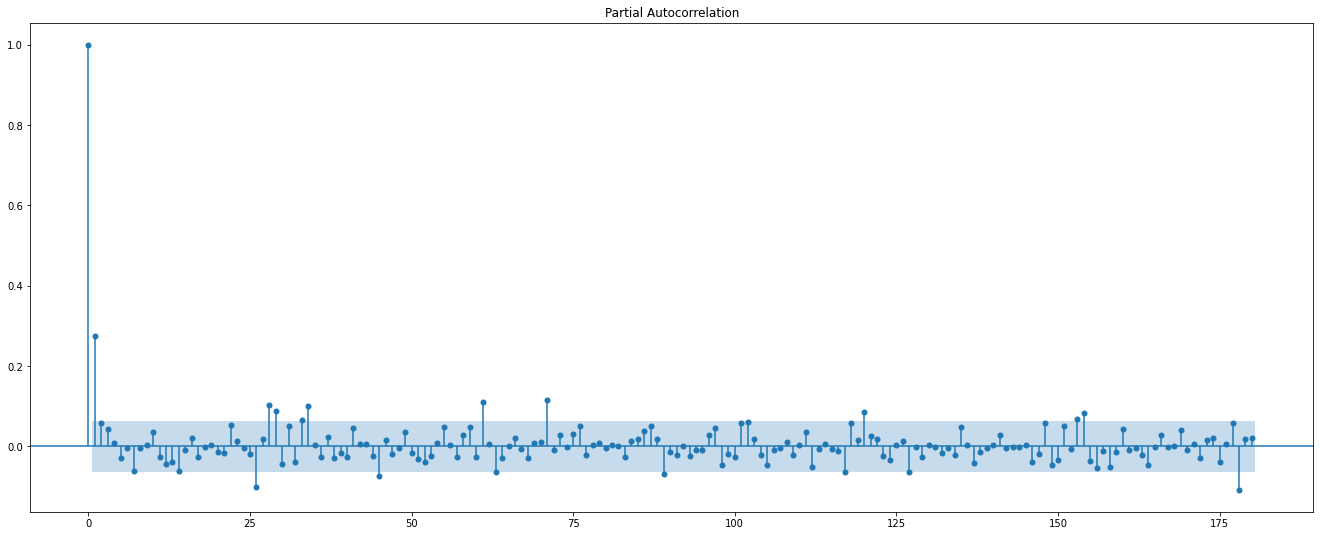

In [114]:
# PACF остатков

plot_pacf(residual, lags=180);

In [115]:
LjungBox(residual, 8)

0.9999999963498701


In [116]:
LjungBox(residual, 10)

0.9999999962224762


In [117]:
LjungBox(residual, 12)

0.9999999957231797


**Вывод по Ljung-Box**:

p-value = 1 > 0.05 = $\alpha$ , значит нулевая гипотеза об отсуствии автокорреляции остатков не отвергается. В результате, делаем вывод об отсутствии автокорреляции остатков.

##### Результаты (0.6 балла)

Постройте суммарный прогноз ETS-модели и модели остатков на тесте. Визуализируйте прогноз и тестовые значения на графике. Подсчитайте MAE прогноза. Добавьте на график прогноз модели из Блока 1. Какая из двух моделей получилась лучше? Как думаете, почему? Обе ли модели смогли пробить порог сезонной наивной модели?

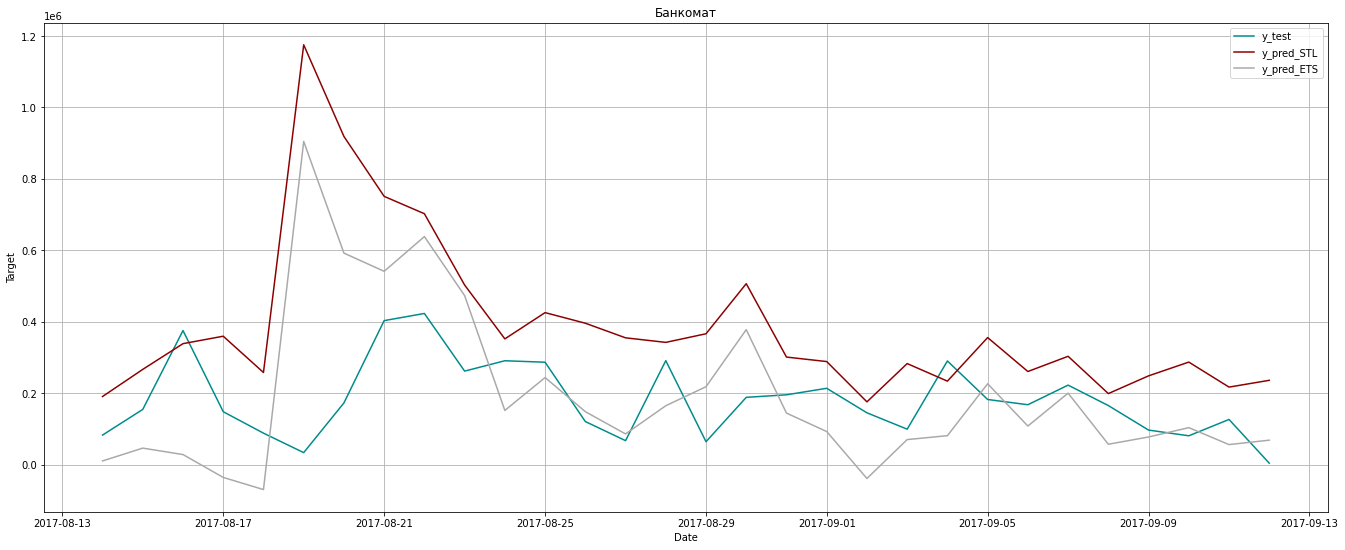

In [118]:
y_pred_ets = y_pred_trend + y_pred_season + y_pred_ets.squeeze() - 100

plt.plot(y_test.index, y_test, label='y_test', color='darkcyan')
plt.plot(y_test.index, y_pred_stl, label='y_pred_STL', color='darkred')
plt.plot(y_test.index, y_pred_ets, label='y_pred_ETS', color='darkgrey')
plt.title('Банкомат')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(visible=1);

In [119]:
mean_absolute_error(y_test, y_pred_ets)

147577.177048323

In [120]:
# Сезонная наивная модель

forecaster_season = NaiveForecaster(sp=30)
forecaster_season.fit(y_train)
y_naive = forecaster_season.predict(fh)

mean_absolute_error(y_test, y_naive)

147860.0

**Вывод**: 

Какая модель получилась лучше. Лучше получилась модель с ETS. Возможным объяснением является тот факт, что ETS модель - это цельная модель, которая заточена не только на декомпозицию ряда, но и на прогноз динамики ряда. STL разложение представляет собой декомпозицию ряда, на которую сверху навешивается прогнозные модели для каждой компонентны. В результате, ETS справляется лучше, так как она в своей задаче оптимизации учитывает взаимодействия ошибки-тренда-сезонности (входят в одну функцию правдоподобия), а STL предполагает отдельное прогнозирование каждой компоненты.

Сезонная наивная модель. Только ETS модель смогла пробить качество сезонной наивной модели. Иногда сложнее не значит лучше!

##### Скиньте мем (Бесценно)

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"

Поделитесь, что вам понравилось, а что нет. Это важно